In [13]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



分析開始: RHT.AX


[*********************100%***********************]  1 of 1 completed


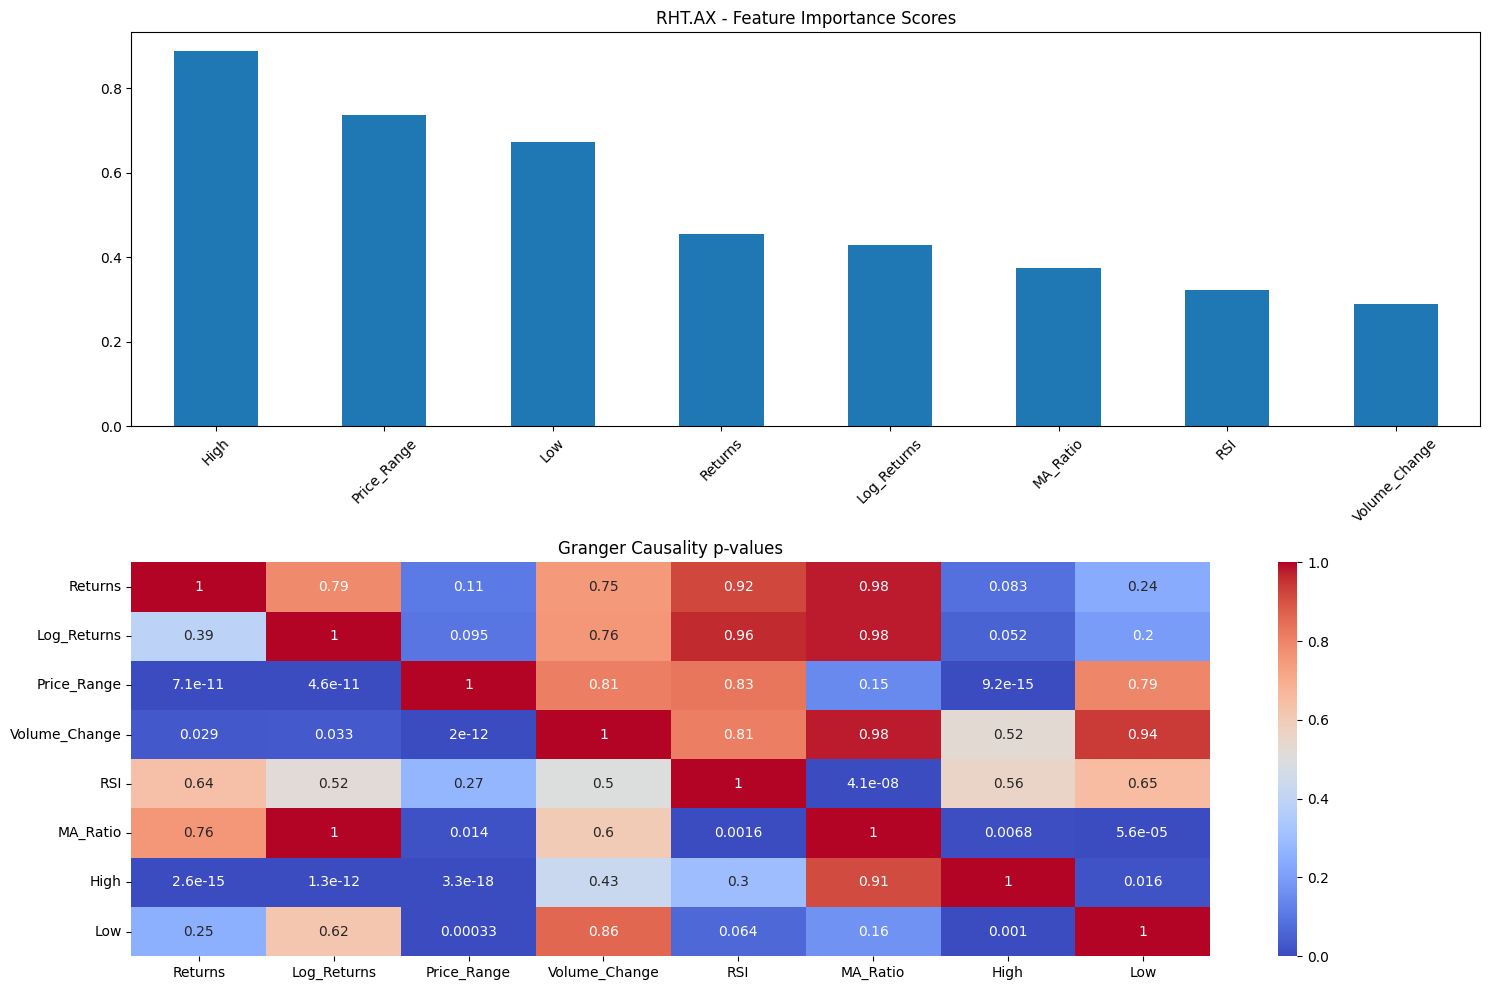


分析開始: PME.AX


[*********************100%***********************]  1 of 1 completed


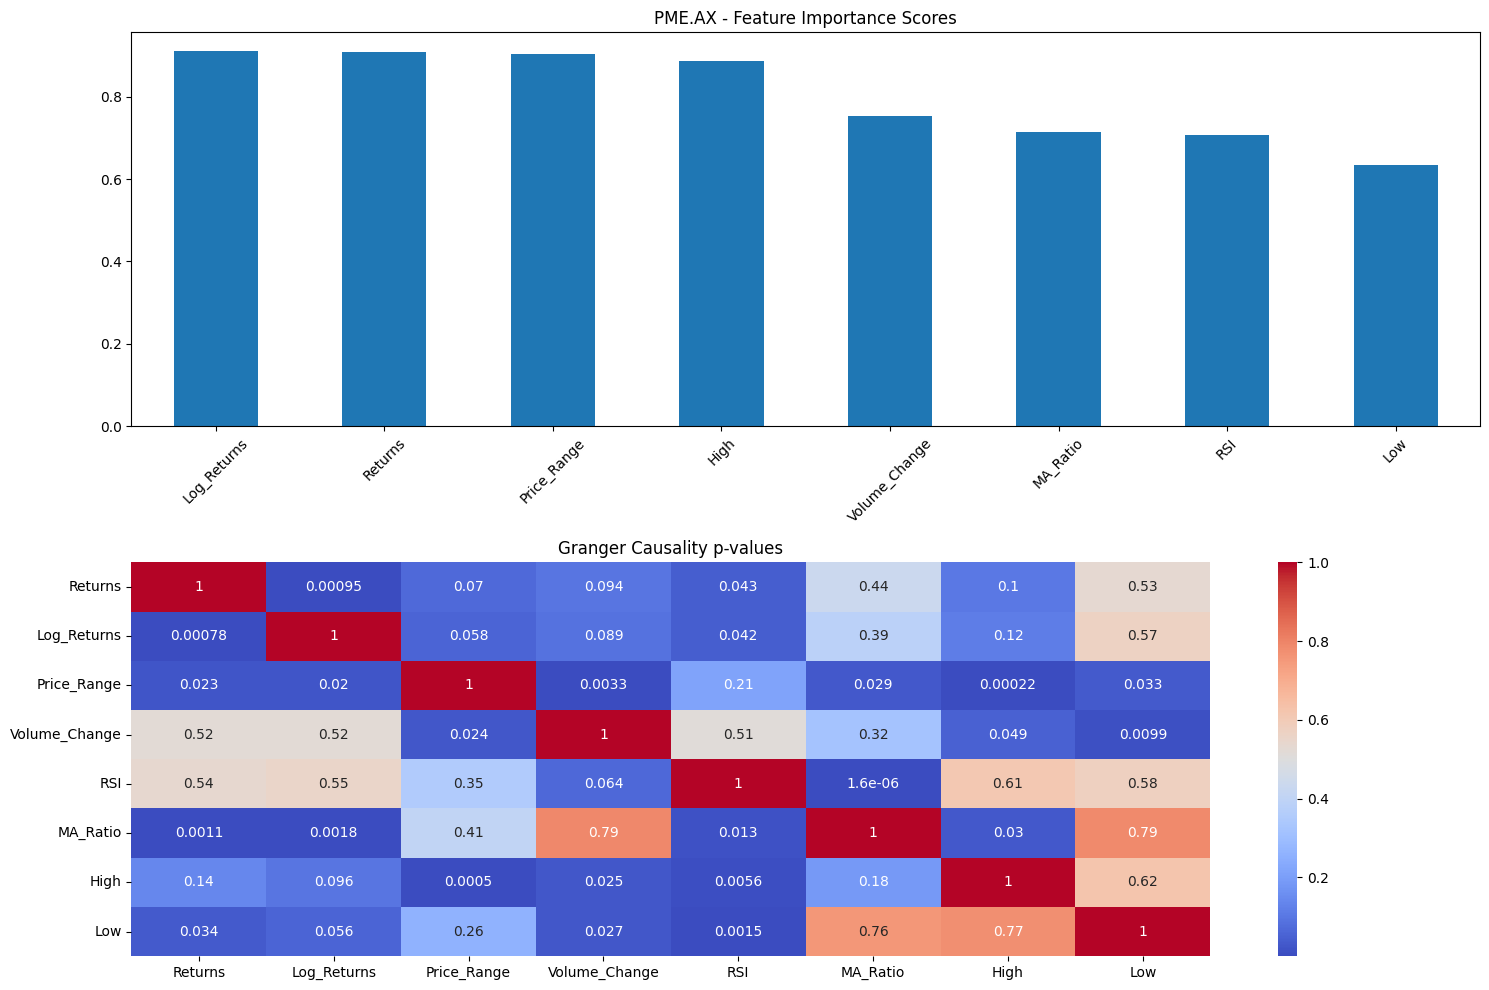

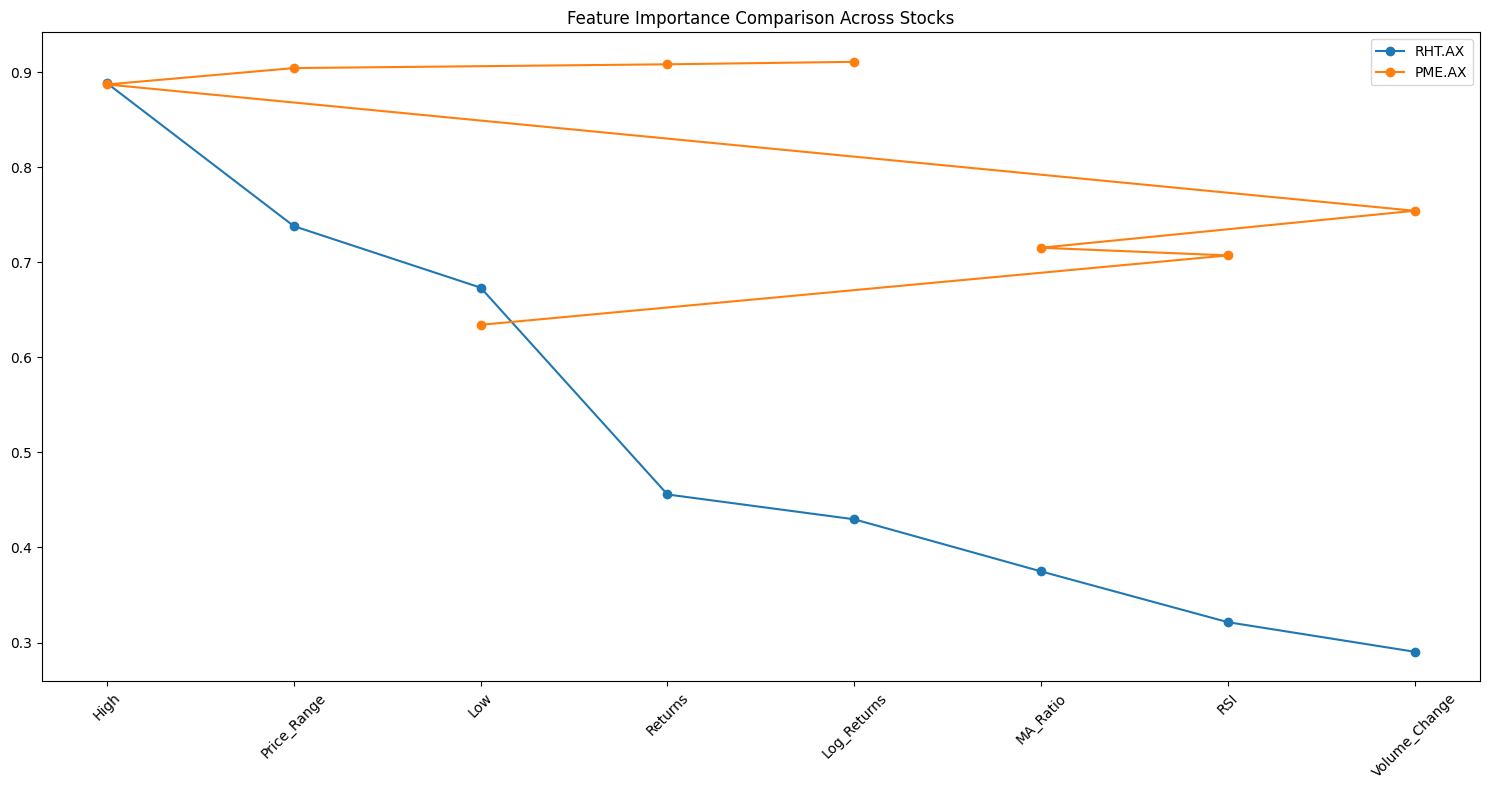

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

def create_features(stock_data):
    """特徴量の作成"""
    df = pd.DataFrame(index=stock_data.index)
    
    # 基本的な価格特徴量
    df['Returns'] = stock_data['Close'].pct_change().clip(-0.5, 0.5)
    df['Log_Returns'] = np.log1p(df['Returns'].clip(-0.4, 0.4))
    
    # 価格レンジ関連
    df['Price_Range'] = np.where(
        stock_data['Close'] > 0,
        (stock_data['High'] - stock_data['Low']) / stock_data['Close'],
        0
    ).clip(-1, 1)
    
    # ボリューム関連
    df['Volume_Change'] = stock_data['Volume'].pct_change().clip(-2, 2)
    
    # RSI
    delta = stock_data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = np.where(loss != 0, gain / loss, 0)
    df['RSI'] = (100 - (100 / (1 + rs))).clip(0, 100)
    
    # 移動平均
    df['MA_Ratio'] = (stock_data['Close'].rolling(window=5).mean() / 
                      stock_data['Close'].rolling(window=20).mean()).clip(0.5, 1.5)
    
    # 高値と安値を特徴量に追加
    df['High'] = stock_data['High']
    df['Low'] = stock_data['Low']
    
    # 異常値の処理
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df

def check_stationarity(series):
    """系列の定常性チェック"""
    try:
        series = series.replace([np.inf, -np.inf], np.nan).dropna()
        if len(series) < 20:
            return False
        result = adfuller(series, regression='ct')
        return result[1] < 0.05
    except:
        return False

def make_stationary(df):
    """データを定常化"""
    stationary_df = pd.DataFrame(index=df.index)
    
    for column in df.columns:
        series = df[column]
        if not check_stationarity(series):
            diff_series = series.diff()
            if not check_stationarity(diff_series):
                diff_series = diff_series.diff()  # 2階差分
            stationary_df[column] = diff_series
        else:
            stationary_df[column] = series
    
    # 異常値の処理と標準化
    stationary_df = stationary_df.replace([np.inf, -np.inf], np.nan)
    stationary_df = stationary_df.fillna(0)
    
    # 各列を標準化
    for column in stationary_df.columns:
        series = stationary_df[column]
        std = series.std()
        if std > 0:
            stationary_df[column] = (series - series.mean()) / std
    
    return stationary_df

def analyze_var_importance(ticker, start_date="2020-01-01", end_date="2024-01-01"):
    """VARモデルによる特徴量重要度分析"""
    try:
        print(f"\n分析開始: {ticker}")
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        
        if len(stock_data) < 100:
            print(f"警告: {ticker}の十分なデータがありません")
            return None
        
        # 特徴量作成
        features_df = create_features(stock_data)
        
        # スケーリング
        scaler = RobustScaler()
        scaled_df = pd.DataFrame(
            scaler.fit_transform(features_df),
            columns=features_df.columns,
            index=features_df.index
        )
        
        # 定常化
        stationary_df = make_stationary(scaled_df)
        
        # 条件数チェック
        cond_num = np.linalg.cond(stationary_df.cov())
        if cond_num > 1e10:
            print(f"警告: 条件数が大きすぎます ({cond_num})")
            return None
        
        # VARモデル
        model = VAR(stationary_df)
        
        # より控えめなラグ次数
        max_lags = min(2, int(len(stationary_df) * 0.01))
        results = model.select_order(maxlags=max_lags)
        order = min(results.selected_orders['aic'], 2)
        
        # モデルフィッティング
        model_fitted = model.fit(order)
        
        # グレンジャー因果性テスト
        causality_matrix = pd.DataFrame(
            np.ones((len(stationary_df.columns), len(stationary_df.columns))),
            index=stationary_df.columns,
            columns=stationary_df.columns
        )
        
        for c1 in stationary_df.columns:
            for c2 in stationary_df.columns:
                if c1 != c2:
                    try:
                        test_result = model_fitted.test_causality(c1, [c2], kind='f')
                        causality_matrix.loc[c1, c2] = test_result.pvalue
                    except:
                        continue
        
        # 結果の可視化
        importance_scores = calculate_importance_scores(causality_matrix)
        visualize_results(ticker, importance_scores, causality_matrix)
        
        return importance_scores, model_fitted, causality_matrix
        
    except Exception as e:
        print(f"エラーが発生しました ({ticker}): {str(e)}")
        return None

def calculate_importance_scores(causality_matrix):
    """重要度スコアの計算"""
    importance_scores = {}
    for column in causality_matrix.columns:
        # より安定した重要度計算
        causes_others = np.median(causality_matrix.loc[column])
        caused_by_others = np.median(causality_matrix[column])
        importance_scores[column] = 1 - (causes_others + caused_by_others) / 2
    return importance_scores

def visualize_results(ticker, importance_scores, causality_matrix):
    """結果の可視化"""
    plt.figure(figsize=(15, 10))
    
    # 特徴量重要度のプロット
    plt.subplot(2, 1, 1)
    importance_series = pd.Series(importance_scores).sort_values(ascending=False)
    importance_series.plot(kind='bar')
    plt.title(f'{ticker} - Feature Importance Scores')
    plt.xticks(rotation=45)
    
    # グレンジャー因果性のヒートマップ
    plt.subplot(2, 1, 2)
    sns.heatmap(causality_matrix, annot=True, cmap='coolwarm', center=0.5)
    plt.title('Granger Causality p-values')
    plt.tight_layout()
    plt.show()

def main():
    tickers = ["RHT.AX", "PME.AX"]
    results = {}

    for ticker in tickers:
        result = analyze_var_importance(ticker)
        if result is not None:
            results[ticker] = {
                'importance_scores': result[0],
                'model': result[1],
                'causality': result[2]
            }

    if len(results) > 1:
        plt.figure(figsize=(15, 8))
        for ticker, result in results.items():
            scores = pd.Series(result['importance_scores']).sort_values(ascending=False)
            plt.plot(scores.index, scores.values, marker='o', label=ticker)
        
        plt.title('Feature Importance Comparison Across Stocks')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()